In [1]:
pip install bokeh

Note: you may need to restart the kernel to use updated packages.


In [1]:
import cv2
import time

import numpy as np
import math
import copy
import asyncio

%matplotlib inline 
import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline

from bokeh.plotting import figure
from bokeh.io import output_notebook, show, push_notebook
from tqdm import tqdm

import IPython.display as Disp
from ipywidgets import widgets

from tdmclient import ClientAsync, aw
client = ClientAsync()
node = await client.wait_for_node()
await node.lock()


Node a13184be-b7ac-45c1-84e9-c4292b7f7ff2

In [2]:
#global initialization 
x_end = y_end=0
# All coordonates are initialized to 0
class RobotState:
    def __init__(self, x=0, y=0, r=0, angle=0):
        self.x = x
        self.y = y
        self.angle = angle 

robot_state = RobotState()

# size of our environment grid
num_cases_x = 8  # horizontal cells (valeur arbitraire ici juste pour que ca marche dans mon exemple) 
num_cases_y = 6   # vertical cells

# Initializing our matrix containing the environment information
center_matrix = [[None for _ in range(num_cases_x)] for _ in range(num_cases_y)] #jsp si c'est comme ca qu'on initialise a zero une matrice
state_matrix = [[None for _ in range(num_cases_x)] for _ in range(num_cases_y)]
debug_matrix = [[None for _ in range(num_cases_x)] for _ in range(num_cases_y)]

#camera related initialization 
cam = cv2.VideoCapture(0)

#Lower the resolution
cam.set(3, 1280)
cam.set(4, 720)

# Initialize a variable to store the last time an image was acquired
last_image_time = time.time()
result, image = cam.read()

state = 1
should_break = False


2023-12-01 17:51:19.159 Python[10809:492554] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.


In [ ]:
def info_robot_cam()
    image_not_good = True
    while image_not_good: 
        ret, frame = cam.read()
        if ret:
            result_image = frame.copy()  # Initialiser result_image avec une copie de l'image actuelle
            filtered_image = pre_processing(result_image)
             # Blob detector parameters for circle detection
            params = cv2.SimpleBlobDetector_Params()
            
            # Create a blob detector with the configured parameters
            detector = cv2.SimpleBlobDetector_create(params)
            
            # Detect blobs in the image
            keypoints = detector.detect(filtered_image)
            
            # Update the info about the robot
            robot_state = robot_info(keypoints, result_image, robot_state)
    
            state_matrix, center_matrix, x_end, y_end = grid_setting(filtered_image,center_matrix,state_matrix)
            
            state_matrix = np.array(state_matrix)
            data = symetrie_lignes(state_matrix)

            for i in range(num_cases_y):
                for j in range(num_cases_x):
                    if state_matrix[i][j] != None: 
                        image_not_good = False
        else:
            print('no image found')
            image_not_good = False

    cam.release()
return data, center_matrix, x_end, y_end, robot_state, result_image

In [ ]:
def calculate_angle_degrees(x1, y1, x2, y2):
    """
    Calculate the angle in degrees between two points (x1, y1) and (x2, y2).
    """
    delta_x = x2 - x1
    delta_y = y2 - y1
    angle_rad = math.atan2(delta_y, delta_x)
    
    # Convert angle to degrees
    angle_degrees = math.degrees(angle_rad)
    
    # Convert angle to be in the range [0, 360)
    angle_degrees = angle_degrees % 360
    print(angle_degrees)
    return angle_degrees

def calculate_distance(x1, y1, x2, y2):
    """
    Calculate the Euclidean distance between two points (x1, y1) and (x2, y2).
    """
    distance = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return distance

In [3]:
def pre_processing(image):
    """    
    Preprocess an image for use in computer vision applications.
    
    Arguments:
    image : The input image to be preprocessed.
        
    Returns:
    filtered_image : The preprocessed image.
    """
    # Convert the image to grayscale for filtering.
    image_grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply bilateral filtering to reduce noise while preserving edges.
    bilateral = cv2.bilateralFilter(image_grey, d=5, sigmaColor=25, sigmaSpace=25)
    
    # Apply Contrast Limited Adaptive Histogram Equalization (CLAHE) for enhancing details.
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    filtered_image1 = clahe.apply(bilateral)
    
    # Apply Gaussian blur to further use 
    filtered_image = cv2.GaussianBlur(filtered_image1, (5, 5), 0)
    
    return filtered_image 

In [4]:
def robot_info(keypoints, result_image, robot_state):
    """
    Update the essential information to describe the state of the robot.
    
    Arguments:
        keypoints: Detected keypoints representing potential robot positions.
        result_image: The image on which to draw the keypoints.
        robot_state: An instance of RobotState containing the coordinates and angle of the robot.
        
    Returns:
        robot_state: The updated RobotState instance.
    """
   
    # Filter by Circularity
    params.filterByCircularity = True
    params.minCircularity = 0.8
    params.maxCircularity = 1
        
    # Filter by color
    params.filterByColor = True

    x=y=r=x_big=y_big=r_big=x_small=y_small=r_small=0 # peut etre je peux enlever ca 

    # Minimum circle radius we want to detect
    small_circle_radius_threshold_max = 14 #(le gros il fais 25 et le petit 18 pour la resolution normale)
    small_circle_radius_threshold_min = 5
    # Check if any blobs (potential circles) were detected
    if keypoints:
#---- 
#     print(f"{len(keypoints)} blobs detected.")
#----                 
        # Draw circles on the original image
        for keypoint in keypoints:
            x = int(keypoint.pt[0])
            y = int(keypoint.pt[1])
            r = int(keypoint.size / 2)

            if small_circle_radius_threshold_min < r < small_circle_radius_threshold_max:
                x_small = x
                y_small = y
                r_small = r
            elif r > small_circle_radius_threshold_max:
                x_big = x
                y_big = y
                r_big = r
#----        
        # print(robot_state.x,robot_state.y,robot_state.r)
   #     print('r_small =', r_small)
  #      print('r_big =', r_big)
        cv2.circle(result_image, (x_big, y_big), r_big, (255, 0, 255), 8) # just to check on the video
        cv2.circle(result_image, (x_small, y_small), r_small, (255, 0, 255), 8) # just to check on the video

           # print(r)
#----
        robot_state.x = x_big
        robot_state.y = y_big
        
        #Robot orientation = angle between the trajectorie of the robot and the vertical axis
        robot_state.angle = calculate_angle_degrees(1, 0, robot_state.x, robot_state.y):

    return robot_state 

In [5]:
def order_points(pts):
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect

def grid_setting(filtered_image, center_matrix, state_matrix):
    BLACK = 1
    WHITE = 0
    black_threshold = 55
    white_threshold = 136
    red_threshold_inf = 56
    red_threshold_sup = 135
    robot_pos_delta_x = 55
    robot_pos_delta_y = 55
    min_area_threshold = 75000

    top_right = top_left = bottom_right = bottom_left =  [0,0]
    x_center = y_center = x_end = y_end = 0

    contours_image = cv2.Canny(filtered_image, 50, 150, apertureSize=3)
    contours, _ = cv2.findContours(contours_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    center_matrix_prev = copy.deepcopy(center_matrix)
    state_matrix_prev = copy.deepcopy(state_matrix)
    
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        if cv2.contourArea(largest_contour) > min_area_threshold:
            peri = cv2.arcLength(largest_contour, True)
            approx = cv2.approxPolyDP(largest_contour, 0.02 * peri, True)
            
            if len(approx) == 4:
                cv2.drawContours(result_image, [approx], -1, (0, 255, 0), 2)
                ordered_points = order_points(approx.reshape(4, 2))

                destination_points = np.array([
                    [0, 0],
                    [filtered_image.shape[1] - 1, 0],
                    [filtered_image.shape[1] - 1, filtered_image.shape[0] - 1],
                    [0, filtered_image.shape[0] - 1]
                ], dtype="float32")
                
                matrix = cv2.getPerspectiveTransform(ordered_points, destination_points)
                warped_image = cv2.warpPerspective(filtered_image, matrix, (filtered_image.shape[1], filtered_image.shape[0]))
                # Right after you calculate the perspective transformation matrix
                inverse_matrix = cv2.invert(matrix)[1]
                        
                # Compute the cell size using the warped image dimensions
                case_width = warped_image.shape[1] // num_cases_x
                case_height = warped_image.shape[0] // num_cases_y
                
                # When mapping the centers back to the original image space
                for i in range(num_cases_y):
                    for j in range(num_cases_x):
                        center_x = j * case_width + case_width // 2
                        center_y = i * case_height + case_height // 2
                        
                        # Convert to a floating-point type
                        float_center = np.array([[[center_x, center_y]]], dtype=np.float32)
                        
                        # Map the centers back to the original image space using the inverse matrix
                        original_center = cv2.perspectiveTransform(float_center, inverse_matrix)
                        original_center = tuple(original_center[0][0].astype(int))
                        
                        # Draw the cell center on the original image
                        cv2.circle(result_image, original_center, 5, (0, 0, 255), -1)
                        
                        # Update center_matrix with the mapped center
                        center_matrix[i][j] = original_center
                        
                        x_center, y_center = original_center  # Unpack the tuple
                        center_value = filtered_image[y_center, x_center]  # Access the image at the y, x coordinates
                        debug_matrix[i][j] = center_value  # Store the grayscale value
                        #Create the state matrix
                        if center_value < black_threshold :
                            if abs(x_center-robot_state.x) <= robot_pos_delta_x and abs(y_center-robot_state.y) <= robot_pos_delta_y:
                                state_matrix[i][j] = WHITE
                            else:
                                state_matrix[i][j] = BLACK     
                        if center_value > white_threshold:
                            state_matrix[i][j] = WHITE
                        if red_threshold_inf <= center_value <= red_threshold_sup:
                            x_end, y_end = center_matrix[i][j]
                            state_matrix[i][j] = WHITE

                        
    else:
        center_matrix = copy.deepcopy(center_matrix_prev)
        state_matrix = copy.deepcopy(state_matrix_prev) # comme ca, si on cache on ne detect pas de controu et on garde notre matrice 
        
    return state_matrix, center_matrix, x_end, y_end


In [6]:
def create_empty_plot(num_cases_x,num_cases_y):
    """
    Helper function to create a figure of the desired dimensions & grid
    
    :param max_val: dimension of the map along the x and y dimensions
    :return: the fig and ax objects.
    """
    fig, ax = plt.subplots(figsize=(7,7))
    
    major_ticks = np.arange(0, num_cases_x+1, 1)
    minor_ticks = np.arange(0, num_cases_y+1, 1)
    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    ax.set_yticks(major_ticks)
    ax.set_yticks(minor_ticks, minor=True)
    ax.grid(which='minor', alpha=0.2)
    ax.grid(which='major', alpha=0.5)
    ax.set_ylim([-1,num_cases_y])
    ax.set_xlim([-1,num_cases_x])
    ax.grid(True)
    
    return fig, ax

In [7]:
def _get_movements_4n():
    """
    Get all possible 4-connectivity movements (up, down, left right).
    :return: list of movements with cost [(dx, dy, movement_cost)]
    """
    return [(1, 0, 1.0),
            (0, 1, 1.0),
            (-1, 0, 1.0),
            (0, -1, 1.0)]

def _get_movements_8n():
    """
    Get all possible 8-connectivity movements. Equivalent to get_movements_in_radius(1)
    (up, down, left, right and the 4 diagonals).
    :return: list of movements with cost [(dx, dy, movement_cost)]
    """
    s2 = math.sqrt(2)
    return [(1, 0, 1.0),
            (0, 1, 1.0),
            (-1, 0, 1.0),
            (0, -1, 1.0),
            (1, 1, s2),
            (-1, 1, s2),
            (-1, -1, s2),
            (1, -1, s2)]

In [9]:
def reconstruct_path(cameFrom, current):
    """
    Recurrently reconstructs the path from start node to the current node
    :param cameFrom: map (dictionary) containing for each node n the node immediately 
                     preceding it on the cheapest path from start to n 
                     currently known.
    :param current: current node (x, y)
    :return: list of nodes from start to current node
    """
    total_path = [current]
    while current in cameFrom.keys():
        # Add where the current node came from to the start of the list
        total_path.insert(0, cameFrom[current]) 
        current=cameFrom[current]
        
#    print(total_path)
    return total_path

def A_Star(start, goal, h, coords, occupancy_grid, movement_type="4N", num_cases_x=num_cases_x, num_cases_y=num_cases_y):
    """
    A* for 2D occupancy grid. Finds a path from start to goal.
    h is the heuristic function. h(n) estimates the cost to reach goal from node n.
    :param start: start node (x, y)
    :param goal_m: goal node (x, y)
    :param occupancy_grid: the grid map
    :param movement: select between 4-connectivity ('4N') and 8-connectivity ('8N', default)
    :return: a tuple that contains: (the resulting path in meters, the resulting path in data array indices)
    """
    # -----------------------------------------
    # DO NOT EDIT THIS PORTION OF CODE
    # -----------------------------------------
    # Check if the start and goal are within the boundaries of the map
  #  for point in [start, goal]: 
  #      for coord in point:
   #         print('coord',coord)
   #         assert coord>=0 and coord<=num_cases_x, "start or end goal not contained in the map"
  #          assert coord>=0 and coord<=num_cases_y, "start or end goal not contained in the map"
   # 
    # Check if the start and goal are within the boundaries of the map
    for point in [start, goal]:
        x_coord, y_coord = point 

        assert 0 <= x_coord < num_cases_x, "X-coordinate of start or end goal not contained in the map"
        assert 0 <= y_coord < num_cases_y, "Y-coordinate of start or end goal not contained in the map"
    
    # check if start and goal nodes correspond to free spaces
    if occupancy_grid[start[0], start[1]]:
        raise Exception('Start node is not traversable')

    if occupancy_grid[goal[0], goal[1]]:
        raise Exception('Goal node is not traversable')
    
    # get the possible movements corresponding to the selected connectivity
    if movement_type == '4N':
        movements = _get_movements_4n()
    elif movement_type == '8N':
        movements = _get_movements_8n()
    else:
        raise ValueError('Unknown movement')
    
    # --------------------------------------------------------------------------------------------
    # A* Algorithm implementation - feel free to change the structure / use another pseudo-code
    # --------------------------------------------------------------------------------------------
    
    # The set of visited nodes that need to be (re-)expanded, i.e. for which the neighbors need to be explored
    # Initially, only the start node is known.
    openSet = [start]
    
    # The set of visited nodes that no longer need to be expanded.
    closedSet = []

    # For node n, cameFrom[n] is the node immediately preceding it on the cheapest path from start to n currently known.
    cameFrom = dict()

    # For node n, gScore[n] is the cost of the cheapest path from start to n currently known.
    gScore = dict(zip(coords, [np.inf for x in range(len(coords))]))
    gScore[start] = 0

    # For node n, fScore[n] := gScore[n] + h(n). map with default value of Infinity
    fScore = dict(zip(coords, [np.inf for x in range(len(coords))]))
    fScore[start] = h[start]

    # while there are still elements to investigate
    while openSet != []:
        
        #the node in openSet having the lowest fScore[] value
        fScore_openSet = {key:val for (key,val) in fScore.items() if key in openSet}
        current = min(fScore_openSet, key=fScore_openSet.get)
        del fScore_openSet
        
        #If the goal is reached, reconstruct and return the obtained path
        if current == goal:
#            print(closedSet)
            return reconstruct_path(cameFrom, current), closedSet

        openSet.remove(current)
        closedSet.append(current)
        
        #for each neighbor of current:
        for dx, dy, deltacost in movements:
            
            neighbor = (current[0]+dx, current[1]+dy)
            
            # if the node is not in the map, skip
            if (neighbor[0] >= occupancy_grid.shape[0]) or (neighbor[1] >= occupancy_grid.shape[1]) or (neighbor[0] < 0) or (neighbor[1] < 0):
                continue
            
            # if the node is occupied or has already been visited, skip
            if (occupancy_grid[neighbor[0], neighbor[1]]) or (neighbor in closedSet): 
                continue
                
            # d(current,neighbor) is the weight of the edge from current to neighbor
            # tentative_gScore is the distance from start to the neighbor through current
            tentative_gScore = gScore[current] + deltacost
            
            if neighbor not in openSet:
                openSet.append(neighbor)
                
            if tentative_gScore < gScore[neighbor]:
                # This path to neighbor is better than any previous one. Record it!
                cameFrom[neighbor] = current
                gScore[neighbor] = tentative_gScore
                fScore[neighbor] = gScore[neighbor] + h[neighbor]

    # Open set is empty but goal was never reached
    print("No path found to goal")
    return [], closedSet

def truncate_coordinate(center_matrix, X, Y):
    threshold_x = 55
    threshold_y = 55
    num_cases_y, num_cases_x = center_matrix.shape[:2]  # Obtention des dimensions de la matrice

    for i in range(num_cases_y):
        for j in range(num_cases_x):
            diff_x = abs(center_matrix[i, j][0] - X)
            diff_y = abs(center_matrix[i, j][1] - Y)

            if diff_x <= threshold_x and diff_y <= threshold_y:
                x_out, y_out = j, i  
  #  for i in range(num_cases_y):
   #     for j in range(num_cases_x):
    #        
     #       if center_matrix[i,j][0] - X <= threshold_x and center_matrix[i,j][1] - Y <= threshold_y:
      #          x_out = j
       #         y_out = i
    
#    if y_out == 0: y_out = 5
 #   if y_out == 1: y_out = 4
  #  if y_out == 2: y_out = 3
   # if y_out == 3: y_out = 2
    #if y_out == 4: y_out = 1
    #if y_out == 5: y_out = 0
  
    return(x_out,y_out)

def symetrie_lignes(matrix):
 
    copy_matrix = copy.deepcopy(matrix)
    matrix[0,:] = copy_matrix[5,:]
    matrix[1,:] = copy_matrix[4,:]
    matrix[2,:] = copy_matrix[3,:]
    matrix[3,:] = copy_matrix[2,:]
    matrix[4,:] = copy_matrix[1,:]
    matrix[5,:] = copy_matrix[0,:]
    return matrix

In [10]:
count = 0
async def rotate_robot(client):
    global x1 ,y1 ,x2 ,y2, motor_left_target, motor_right_target,angle,move_list,count
    angle = calculate_angle_degrees(x1, y1, x2, y2)
    print('count =', count)
    
    if move_list[count] == angle :
        angle = 0
    else :
        move_list[count+1] = angle
        angle = angle - move_list[count]
        count = count+1
    print(move_list)
    
    if angle < 0 :
        angle = -angle
        time_rotation = (4.95 * angle) / 180
        v = {
            "motor.left.target": [int(100)],
            "motor.right.target": [int(-100)],
    }
        await node.set_variables(v)
        await asyncio.sleep(time_rotation)
    else:
        time_rotation = (4.95 * angle) / 180
        if time_rotation == 0 :
            v_reverse = {
            "motor.left.target": [int(100)],
            "motor.right.target": [int(100)],
        }
        else :
            v_reverse = {
                "motor.left.target": [int(-100)],
                "motor.right.target": [int(100)],
            }
        await node.set_variables(v_reverse)
        await asyncio.sleep(time_rotation)
    v_stop = {
            "motor.left.target": [int(0)],
            "motor.right.target": [int(0)],
        }
    await node.set_variables(v_stop)
   
    
    
    
async def move_robot(client):
    global x1 ,y1 ,x2 ,y2, motor_left_target, motor_right_target,distance
    distance = calculate_distance(x1, y1, x2, y2)
    time_distance = distance*4.5
    v = {
            "motor.left.target": [int(100)],
            "motor.right.target": [int(100)],
    }
    await node.set_variables(v)
    await asyncio.sleep(time_distance)
    v_stop = {
            "motor.left.target": [int(0)],
            "motor.right.target": [int(0)],
        }
    await node.set_variables(v_stop)
    
async def A_star_move(client):
    global x1, y1, x2, y2, motor_left_target, motor_right_target, move_list
    fig, ax = create_empty_plot(num_cases_x,num_cases_y)
     # Creating the occupancy grid
            center_matrix_array = np.array(center_matrix)
            center_matrix_array = symetrie_lignes(center_matrix_array)
                
            cmap = colors.ListedColormap(['white', 'red']) # Select the colors with which to display obstacles and free cells    
                
            # Converting the random values into occupied and free cells
            limit = 0
            occupancy_grid = data.copy()

            
            occupancy_grid[data>limit] = 1
            occupancy_grid[data<=limit] = 0
            occupancy_grid= occupancy_grid.transpose()

            # Displaying the map
            ax.imshow(occupancy_grid.transpose(), cmap=cmap)
            plt.title("Map : free cells in white, occupied cells in red");
            start_x = robot_state.x
            start_y = robot_state.y
            start = truncate_coordinate(center_matrix_array,robot_state.x, robot_state.y)
            goal = truncate_coordinate(center_matrix_array, x_end, y_end)
        
            print('goal',goal)
            print('start',start)
            
            x,y = np.mgrid[0:num_cases_x:1, 0:num_cases_y:1]
            pos = np.empty(x.shape + (2,))
            pos[:, :, 0] = x; pos[:, :, 1] = y
            pos = np.reshape(pos, (x.shape[0]*x.shape[1], 2))
            coords = list([(int(x[0]), int(x[1])) for x in pos])

            # Run the A* algorithm
            h = np.linalg.norm(pos - goal, axis=-1)
            h = dict(zip(coords, h))
#            print(occupancy_grid)
            path, visitedNodes = A_Star(start, goal, h, coords, occupancy_grid, movement_type="4N")
            path = np.array(path).reshape(-1, 2).transpose()
            visitedNodes = np.array(visitedNodes).reshape(-1, 2).transpose()

            # Displaying the map
            fig_astar, ax_astar = create_empty_plot(num_cases_x,num_cases_y)
            ax_astar.imshow(occupancy_grid.transpose(), cmap=cmap)

            # Plot the best path found and the list of visited nodes
            ax_astar.scatter(visitedNodes[0], visitedNodes[1], marker="o", color = 'orange');
            ax_astar.plot(path[0], path[1], marker="o", color = 'blue');
            ax_astar.scatter(start[0], start[1], marker="o", color = 'green', s=200);
            ax_astar.scatter(goal[0], goal[1], marker="o", color = 'purple', s=200);
            
            # Displaying the map
            fig_astar, ax_astar = create_empty_plot(num_cases_x,num_cases_y)
            ax_astar.imshow(occupancy_grid.transpose(), cmap=cmap)
                
            # Plot the best path found and the list of visited nodes
            ax_astar.scatter(visitedNodes[0], visitedNodes[1], marker="o", color = 'orange');
            ax_astar.plot(path[0], path[1], marker="o", color = 'blue');
            ax_astar.scatter(start[0], start[1], marker="o", color = 'green', s=200);
            ax_astar.scatter(goal[0], goal[1], marker="o", color = 'purple', s=200);
            
            print(len(path))
            move_list = [0] * len(path)
            print(move_list)
            for i in range(len(path)-1):
                x1, y1 = path[i]
                x2, y2 = path[i + 1]
                rotate_task = asyncio.create_task(rotate_robot(client))
                await rotate_task
                drive_task = asyncio.create_task(move_robot(client))
            # Wait for both tasks to complete
                await drive_task   
           


goal (2, 0)
start (1, 2)
6
[0, 0, 0, 0, 0, 0]
180.0
count = 0
[0, 180.0, 0, 0, 0, 0]
270.0
count = 1
[0, 180.0, 270.0, 0, 0, 0]
270.0
count = 2
[0, 180.0, 270.0, 0, 0, 0]
0.0
count = 2
[0, 180.0, 270.0, 0.0, 0, 0]
0.0
count = 3
[0, 180.0, 270.0, 0.0, 0, 0]


2023-12-01 17:52:15.395 Python[10809:492554] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.


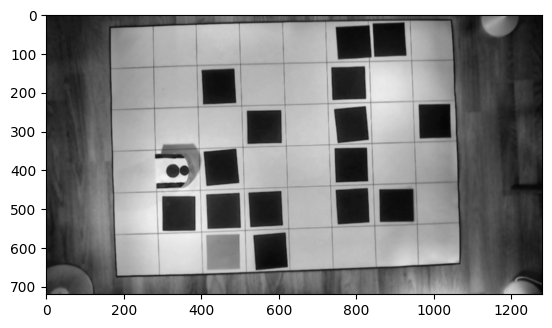

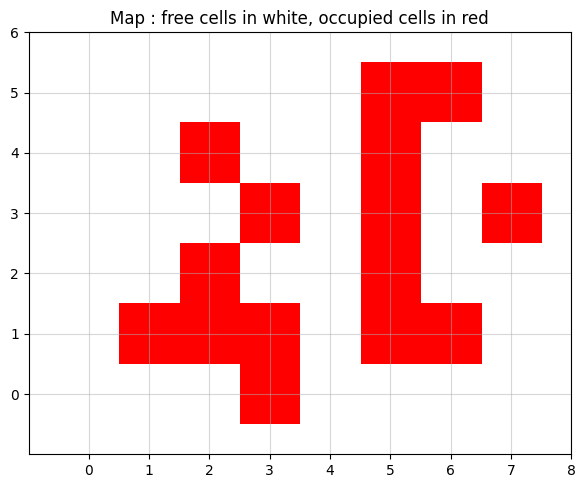

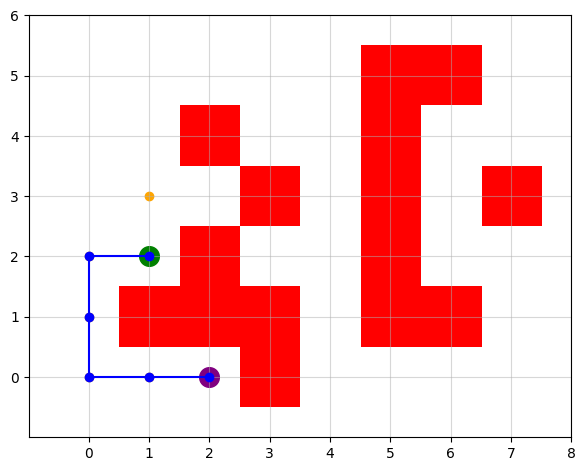

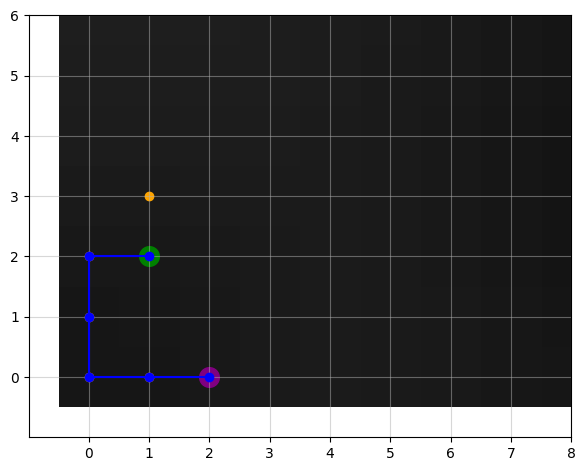

Exception in thread Thread-5:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tdmclient/tcp.py", line 73, in run
    packet = self.read_packet()
             ^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tdmclient/tcp.py", line 66, in read_packet
    raise error
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tdmclient/tcp.py", line 59, in read_packet
    packet_len = self.read_uint32()
                 ^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tdmclient/tcp.py", line 46, in read_uint32
    b = self.io.read(4)
        ^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packa

In [13]:
while True:
    start_time = time.time()  # Record the start time
    ret, frame = cam.read()
    if ret:
        result_image = frame.copy()  # Initialiser result_image avec une copie de l'image actuelle
        
        filtered_image = pre_processing(result_image)
        plt.imshow(cv2.cvtColor(filtered_image, cv2.COLOR_BGR2RGB))
        # Blob detector parameters for circle detection
        params = cv2.SimpleBlobDetector_Params()
        
        # Create a blob detector with the configured parameters
        detector = cv2.SimpleBlobDetector_create(params)
        
        # Detect blobs in the image
        keypoints = detector.detect(filtered_image)
        
        # Update the info about the robot
        robot_state = robot_info(keypoints, result_image, robot_state)

        state_matrix, center_matrix, x_end, y_end = grid_setting(filtered_image,center_matrix,state_matrix)
        
        state_matrix = np.array(state_matrix)
        data = symetrie_lignes(state_matrix)

        if state == 0 :
            continue
        elif state == 1 :
            for i in range(num_cases_y):
                if should_break:  # Vérifiez si nous devons sortir de la boucle externe
                    break

                for j in range(num_cases_x):
                    if state_matrix[i][j] == None:
                        should_break = True  # Préparez-vous à sortir des deux boucles
                        break  # Sortez de la boucle interne
                        
            state = 2

            async def main():
                do_task = asyncio.create_task(A_star_move(client))
                await do_task
            await main()
   
        cv2.imshow('Live Footage', result_image)

        #if you click on any key it stops the program
        if cv2.waitKey(1) == 27:
            break
            
            # Wait until a second has passed since the start of the iteration
        while time.time() - start_time < 1:
            time.sleep(0.01) 
    else:
        break

# Release the camera and close the window
cam.release()
cv2.destroyAllWindows()
for i in range(1, 5):
    cv2.waitKey(1)